In [1]:
import os
#import gradio as gr
#import fire
from enum import Enum
from threading import Thread
from transformers import AutoModelForCausalLM, AutoTokenizer
from auto_gptq import AutoGPTQForCausalLM
from llama_cpp import Llama
from huggingface_hub import hf_hub_download
from transformers import TextIteratorStreamer
#from llama_chat_format import format_to_llama_chat_style
from ctransformers import AutoModelForCausalLM
import json
import pandas as pd
import os
import re
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import numpy as np
import torch

In [12]:
def fewRel(path):
    data_list = []  # Create a list to collect dictionaries for each row
    sentences = []
    relations = []
    entities = []
    data = {}
    for filename in os.listdir(path):
        if not filename.endswith('.json'):
            continue
        fullname = os.path.join(path, filename)
        
        with open(fullname) as f:
            fewRel_corpus = json.load(f)
            
            for relation, value in fewRel_corpus.items():
                for row in value:
                    sentences.append(row['tokens'])
                    relations.append(relation)
                    entities.append((row['h'][0].strip(),row['t'][0].strip()))
        data['sentence'] = sentences
        data['relation'] = relations
        data['entities'] = entities
    
    return data

In [13]:
df = pd.DataFrame(fewRel('data/'))

In [14]:
def random_rows_per_category(group):
    return group.sample(n=1, random_state=42) 

In [15]:
random_rows = df.groupby('relation', group_keys=False).apply(random_rows_per_category)

In [16]:
example = "'The FBI has jurisdiction over federal and local government in Texas.' is augumented to 'he CCB has jurisdiction over regional and local government in Brazil.'"

In [17]:
question = 'Write 5 augumented sentences of the following text' + example + ' text ='

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Important: The prompt needs to be in the same format the model was trained with.
# You can find an example prompt in the experiment logs.


quantization_config = None
# optional quantization
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
)

tokenizer = AutoTokenizer.from_pretrained(
    "h2oai/h2ogpt-gm-oasst1-en-2048-falcon-40b-v2",
    use_fast=False,
    padding_side="left",
    trust_remote_code=True,
)
model = AutoModelForCausalLM.from_pretrained(
    "h2oai/h2ogpt-gm-oasst1-en-2048-falcon-40b-v2",
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map={"": "cuda:0"},
    quantization_config=quantization_config
).eval()



Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

In [21]:
from tqdm import tqdm

In [22]:
all_augumented_data = []
for i in tqdm(range(10)):
    random_rows = df.groupby('relation', group_keys=False).apply(random_rows_per_category)
    for index, row in random_rows.iterrows():
        single_aug_data = {}
        sent = ' '.join(row['sentence'])
        augumented_text = process_data(llmFalcon("<|prompt|>"+question + sent+"<|endoftext|><|answer|>"))
        #print(process_data(augumented_text))
        single_aug_data['sentences'] = augumented_text
        single_aug_data['relation'] = row['relation']
        single_aug_data['entities'] = row['entities']
       # output = augumented_text +", " + row['relation'] + ", " +  row['entities'][0] +", " +  row['entities'][1]
        all_augumented_data.append(single_aug_data)

  0%|          | 0/10 [00:00<?, ?it/s]/upb/users/m/manzoor/profiles/unix/cs/.local/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

In [10]:
prompt = "<|prompt|>Write 5 augumented sentences of the followingtext ='The Malik live in Pakistan.'<|endoftext|><|answer|>"

In [19]:
def process_data(text):
    sentences = re.split(r'\d+\.\s+', text)
    sentences = [sentence for sentence in sentences if sentence.strip()]    
    return sentences

In [18]:
def llmFalcon(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False,return_token_type_ids=False).to("cuda")

    # generate configuration can be modified to your needs
    tokens = model.generate(
        **inputs,
        min_new_tokens=2,
        max_new_tokens=1024,
        do_sample=False,
        num_beams=1,
        temperature=float(0.3),
        repetition_penalty=float(1.2),
        renormalize_logits=True
    )[0]

    tokens = tokens[inputs["input_ids"].shape[1]:]
    answer = tokenizer.decode(tokens, skip_special_tokens=True)
    return answer

In [23]:
def save(file_path,data):
    with open(file_path, "w") as json_file:
        json.dump(data, json_file)

    print(f'Data saved to {file_path}')

In [34]:
file_path = "nyt_less100_100Plus_Falcon40_data"
save(file_path,all_augumented_data)

Data saved to augumented_data/nyt_50_Falcon40_data.json


In [73]:
len(all_augumented_data)

240

In [33]:
def nytFb(path):
    dist = "train"
    
    temp_sent = ""
    
    temp_rel = ""
    data = {}
    data_list = []  # Create a list to collect dictionaries for each row
    sentences = []
    relations = []
    entities = []
   
    for filename in os.listdir(path):
        if not filename.endswith('.json'): continue
        fullname = os.path.join(path, filename)
       
        if filename == "test.json":
            dist = 'test'
        elif filename == "train.json":
            dist = 'train'
        else:
            dist = 'valid'
        data2 = pd.read_json(r''+ fullname, lines=True)
        print(data2.head())
        return data2
       
    return data

In [28]:
data_nyt = nytFb('data/nyt/')

                                            sentText  \
0  Massachusetts ASTON MAGNA Great Barrington ; a...   
1  North Carolina EASTERN MUSIC FESTIVAL Greensbo...   
2  It will be the final movie credited to Debra H...   
3  In a 3-0 victory over the Crew on Saturday in ...   
4  The United States ambassador to Mexico , Tony ...   

                                           articleId  \
0  /m/vinci8/data1/riedel/projects/relation/kb/ny...   
1  /m/vinci8/data1/riedel/projects/relation/kb/ny...   
2  /m/vinci8/data1/riedel/projects/relation/kb/ny...   
3  /m/vinci8/data1/riedel/projects/relation/kb/ny...   
4  /m/vinci8/data1/riedel/projects/relation/kb/ny...   

                                    relationMentions  \
0  [{'em1Text': 'Annandale-on-Hudson', 'em2Text':...   
1  [{'em1Text': 'North Carolina', 'em2Text': 'Gre...   
2  [{'em1Text': 'Debra Hill', 'em2Text': 'Haddonf...   
3  [{'em1Text': 'Ohio', 'em2Text': 'Columbus', 'l...   
4  [{'em1Text': 'Mexico', 'em2Text': 'Nuevo La

In [29]:
nyt_df = pd.DataFrame(columns=['sentences', 'relation', 'entities'])

# Loop through the original DataFrame and perform data manipulation
for index, row in data_nyt.iterrows():
    # Perform your data manipulation here
    sentence = row['sentText']
    relation = row['relationMentions'][0]['label'].split('/')[-1] 
    ent1 = row['entityMentions'][0]['text']
    ent2 = row['entityMentions'][1]['text']
    entities = (ent1, ent2)

    # Create a temporary DataFrame for the current row
    temp_df = pd.DataFrame({'sentences': [sentence], 'relation': [relation], 'entities': [entities]})

    # Concatenate the temporary DataFrame with the new_df
    nyt_df = pd.concat([nyt_df, temp_df], ignore_index=True)

In [30]:
nyt_df.head()

,sentences,relation,entities
0,Massachusetts ASTON MAGNA Great Barrington ; a...,contains,"(Bard College, Annandale-on-Hudson)"
1,North Carolina EASTERN MUSIC FESTIVAL Greensbo...,contains,"(North Carolina, Greensboro)"
2,It will be the final movie credited to Debra H...,place_of_birth,"(Debra Hill, Haddonfield)"
3,In a 3-0 victory over the Crew on Saturday in ...,contains,"(Columbus, Ohio)"
4,"The United States ambassador to Mexico , Tony ...",contains,"(United States, Mexico)"


In [31]:
all_augumented_data = []
for i in tqdm(range(10)):
    random_rows = nyt_df.groupby('relation', group_keys=False).apply(random_rows_per_category)
    for index, row in random_rows.iterrows():
        single_aug_data = {}
        sent = row['sentences']
        augumented_text = process_data(llmFalcon("<|prompt|>"+question + sent+"<|endoftext|><|answer|>"))
        #print(process_data(augumented_text))
        single_aug_data['sentences'] = augumented_text
        single_aug_data['relation'] = row['relation']
        single_aug_data['entities'] = row['entities']
       # output = augumented_text +", " + row['relation'] + ", " +  row['entities'][0] +", " +  row['entities'][1]
        all_augumented_data.append(single_aug_data)

  0%|          | 0/10 [00:00<?, ?it/s]/upb/users/m/manzoor/profiles/unix/cs/.local/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

In [35]:
category_counts = nyt_df['relation'].value_counts()

print(category_counts)

relation
contains                    30240
nationality                  5219
place_lived                  5024
company                      3971
capital                      2430
neighborhood_of              2108
place_of_birth               1580
administrative_divisions     1518
country                      1517
place_of_death               1023
children                      381
founders                      377
place_founded                 318
major_shareholder_of           98
teams                          88
location                       86
major_shareholders             84
religion                       53
advisors                       34
geographic_distribution        26
ethnicity                       9
people                          9
profession                      2
industry                        1
Name: count, dtype: int64


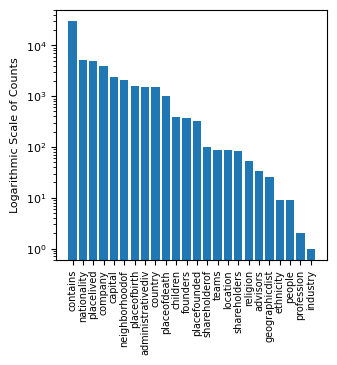

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3.5, 3.25))  # Set the figure size (adjust as needed)

plt.bar(listname, values)
plt.yscale('log')  # Use a logarithmic scale on the x-axis

# Add labels and title
#plt.xlabel('Relations', fontsize=10)  # Adjust fontsize as needed
plt.ylabel('Logarithmic Scale of Counts', fontsize=8)  # Adjust fontsize as needed
plt.yticks(fontsize=8)  # Adjust fontsize for y-axis labels

# Rotate x-axis labels vertically
plt.xticks(listname, rotation='vertical', fontsize=7)  # Rotate x-axis labels to vertical

# Uncomment the line below if you want to invert the y-axis
# plt.gca().invert_yaxis()  # Invert the y-axis for labels to be at the top

plt.savefig('nyt_relation_distribution.pdf', format='pdf', dpi=1048, bbox_inches='tight')

# Show the chart
plt.show()


In [58]:
category_counts.values

array([30240,  5219,  5024,  3971,  2430,  2108,  1580,  1518,  1517,
        1023,   381,   377,   318,    98,    88,    86,    84,    53,
          34,    26,     9,     9,     2,     1])

In [62]:
listname = ['contains', 'nationality', 'placelived', 'company', 'capital',
       'neighborhoodof', 'placeofbirth', 'administrativediv',
       'country', 'placeofdeath', 'children', 'founders', 'placefounded',
       'shareholderof', 'teams', 'location', 'shareholders',
       'religion', 'advisors', 'geographicdist', 'ethnicity',
       'people', 'profession', 'industry']

In [59]:
values = [30240,  5219,  5024,  3971,  2430,  2108,  1580,  1518,  1517,
        1023,   381,   377,   318,    98,    88,    86,    84,    53,
          34,    26,     9,     9,     2,     1]

In [69]:
threshold = 100

# Filter categories with counts less than the threshold
categories_below_threshold = category_counts[category_counts < threshold]

# Create two separate DataFrames based on the filter
df_below_threshold = nyt_df[nyt_df['relation'].isin(categories_below_threshold.index)]
df_above_threshold = nyt_df[~nyt_df['relation'].isin(categories_below_threshold.index)]


In [72]:
all_augmented_data = []

    # Iterate using tqdm for a progress bar
for i in tqdm(range(20), desc="Processing"):
    random_rows = df_below_threshold.groupby('relation', group_keys=False).apply(random_rows_per_category)

    for index, row in tqdm(random_rows.iterrows()):
        single_aug_data = {}
        sent = row['sentences']
        augumented_text = process_data(llmFalcon("<|prompt|>"+question + sent+"<|endoftext|><|answer|>"))

        single_aug_data['sentences'] = augumented_text
        single_aug_data['relation'] = row['relation']
        single_aug_data['entities'] = row['entities']

        all_augmented_data.append(single_aug_data)

Processing:   0%|          | 0/20 [00:00<?, ?it/s]
0it [00:00, ?it/s]/upb/users/m/manzoor/profiles/unix/cs/.local/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

1it [00:51, 51.01s/it]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

2it [01:09, 31.93s/it]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

3it [01:25, 24.70s/it]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

4it [01:43, 21.89s/it]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

5it [02:04, 21.72s/it]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

6it [02:24, 21.20s/it]Setting `pad_token_id` to `eos_token_

In [74]:
len(all_augmented_data)

220

In [77]:
file_path = "augumented_data/nyt_less100_100Plus_Falcon40_data.json"
save(file_path,all_augmented_data)

Data saved to augumented_data/nyt_less100_100Plus_Falcon40_data.json
